# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
%%time
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.
CPU times: user 1.34 s, sys: 239 ms, total: 1.58 s
Wall time: 1min 4s


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726671e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
i_episode = 0
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    i_episode += 1
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}. Number of episodes: {}.'.format(np.mean(scores),
                                                                                            i_episode-1))

Total score (averaged over agents) this episode: 0.0. Number of episodes: 1000.


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 5. Submission

> The following solution is based on the code provided in [Udacity ddpg-bipedal](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/DDPG.ipynb). In particular, it uses the files [model.py](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/model.py) and [ddpg_agent/py](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-bipedal/ddpg_agent.py), as well as the code provided in the training loop `ddpg()`.

In [7]:
import random
import datetime, time
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from workspace_utils import active_session

from ddpg_agent import Agent

#### Learning Algorithm

DDPG

####  Neural Network Architecture

After trying the initial architecture from the Udacity bipolar walker, and reading in the student hub I adapted the model as follows:

For the **actor** I added another fully connected layer with 128 neurons.
This results in the following number of neurons on each layer then (input, FC1, FC2, output): `33-256-128-4`.
Besides, a batch normalization layer is being introduced in between the fully connected layers, to help normalize the activation across the batch of samples from the replay buffer

The **critic** is adjusted in the following way:
128-128

In [8]:
agent = Agent(state_size=state_size,
              action_size=action_size,
              random_seed=5)

def ddpg(n_episodes=750, max_t=700):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        t_start = datetime.datetime.now()
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        for t in range(max_t):
            print('\rEpisode {}/{}, t: {}/{}'.format(i_episode, n_episodes, t, max_t),
                  end="")
            action = agent.act(states)
            
            env_info = env.step(actions)[brain_name]     # send all actions to the environment
            next_state = env_info.vector_observations[0] # get next state (for each agent)
            reward = env_info.rewards[0]                 # get reward (for each agent)
            done = env_info.local_done[0]                # see if episode finished
            
            score += reward
            state = next_state                           # roll over states to next time step
            
            # next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done, t)
            # state = next_state
            # score += reward
            
            if done:                                     # exit loop if episode finished
                break
                
        scores_deque.append(score)
        scores.append(score)
        t_episode = datetime.datetime.now() - t_start
        print('\rEpisode: {}, Average Score: {:.2f}, Score: {:.2f}, time: {}\n'.format(i_episode,
            np.mean(scores_deque), score, t_episode), end="")
        
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\nEpisode: {}, Average Score: {:.2f}\n'.format(i_episode,
                                                             np.mean(scores_deque)))

        if np.mean(scores_deque) >= 30.0:
            print('\n\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_solution.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_solution.pth')
            break
            
    return scores

In [10]:
%%time
with active_session():
    scores = ddpg()

Episode: 1, Average Score: 0.00, Score: 0.00, time: 0:00:04.376297
Episode: 2, Average Score: 0.01, Score: 0.03, time: 0:00:09.097648
Episode: 3, Average Score: 0.01, Score: 0.00, time: 0:00:08.500119
Episode: 4, Average Score: 0.03, Score: 0.09, time: 0:00:08.514196
Episode: 5, Average Score: 0.02, Score: 0.00, time: 0:00:08.564087
Episode: 6, Average Score: 0.02, Score: 0.00, time: 0:00:08.591026
Episode: 7, Average Score: 0.02, Score: 0.04, time: 0:00:08.734327
Episode: 8, Average Score: 0.02, Score: 0.01, time: 0:00:08.724934
Episode: 9, Average Score: 0.05, Score: 0.28, time: 0:00:08.581125
Episode: 10, Average Score: 0.08, Score: 0.34, time: 0:00:08.626510
Episode: 11, Average Score: 0.08, Score: 0.09, time: 0:00:08.616995
Episode: 12, Average Score: 0.09, Score: 0.21, time: 0:00:08.844271
Episode: 13, Average Score: 0.12, Score: 0.47, time: 0:00:08.834926
Episode: 14, Average Score: 0.15, Score: 0.58, time: 0:00:08.825672
Episode: 15, Average Score: 0.16, Score: 0.24, time: 0:00

Episode: 121, Average Score: 0.26, Score: 0.12, time: 0:00:09.482673
Episode: 122, Average Score: 0.26, Score: 0.00, time: 0:00:09.482035
Episode: 123, Average Score: 0.26, Score: 0.37, time: 0:00:09.427284
Episode: 124, Average Score: 0.26, Score: 0.07, time: 0:00:09.449357
Episode: 125, Average Score: 0.25, Score: 0.37, time: 0:00:09.442164
Episode 126/750, t: 40/700

KeyboardInterrupt: 

In [11]:
# With Batch size 128:
# Episode 100 Average Score: 0.26
# Episode 200 Average Score: 0.28

# With batch size 1024
# Episode 100 Average Score: 0.51 Score: 0.51 Score: 0.32
# Episode 200 Average Score: 0.54 Score: 0.54 Score: 0.64
# Episode 227/1000, t: 527/700

# With batch size 512, added LeakyRelu to Actor and Critic, added BatchNormalization to Critic as well
# Episode 135: Average Score: 0.01, Score: 0.12, time: 0:00:16.574757
# Episode 136: Average Score: 0.01, Score: 0.11, time: 0:00:16.618869

# With 256-128 network and clip grad norm

# With 256-256 network and Batch size 512 and clip grad norm


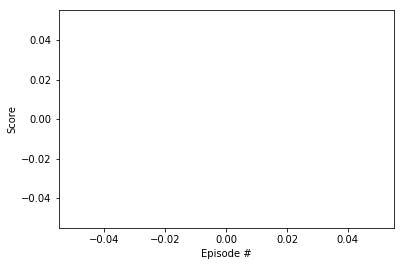

In [12]:
def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

plot_scores(scores)